# Wildfire Project by Victor Jin

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import glob
import cv2
import numpy as np # linear algebra
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import montage

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
data_dir = 'dataset'
train_image_dir = os.path.join(data_dir, 'train')
test_image_dir = os.path.join(data_dir, 'test')
import gc; gc.enable() # memory is tight

from skimage.morphology import label
data_dir = './dataset'
train_image_dir = os.path.join(data_dir, 'train')
image_filenames = os.listdir(train_image_dir)

def get_all():
    img_path = os.path.join(train_image_dir, 'images')
    images = glob.glob(os.path.join(img_path, '*.*'))
    return [image.split('/')[-1] for image in images]
def get_all_imgs():
    img_path = os.path.join(train_image_dir,'images')
    images = glob.glob(os.path.join(img_path,'*.*'))
    return [os.path.basename(image) for image in images]
ALL_IMGS = get_all_imgs()

#### Import all dataset, including mask. Preprocess the images by resizing and converting masks to binary while importing

In [3]:
x = list()
y = list()
img_path = os.path.join(train_image_dir,'images')
mask_path = os.path.join(train_image_dir,'masks')
for filename in ALL_IMGS:
    c_img = imread(os.path.join(img_path, filename), cv2.IMREAD_GRAYSCALE)
#     print(c_img.shape)
    c_img = tf.image.resize(c_img, (128, 128))
    c_mask = imread(os.path.join(mask_path, filename), cv2.IMREAD_GRAYSCALE)
    #     c_mask = tf.image.decode_jpeg(c_mask)
#     print(c_mask.shape)
    try:
        c_mask = cv2.cvtColor(c_mask, cv2.COLOR_BGR2GRAY)
    except:
        pass
    (thresh, c_mask) = cv2.threshold(c_mask, 240, 255, cv2.THRESH_BINARY)
    c_mask = cv2.resize(c_mask, (128, 128), interpolation = cv2.INTER_AREA)
    c_mask = tf.expand_dims(c_mask, axis=2)
#     print(c_mask.shape)
#     c_mask = tf.image.resize(c_mask, (128, 128))
#     print(c_img.shape)
#     (thresh, c_mask) = cv2.threshold(c_mask, 240, 255, cv2.THRESH_BINARY)
    x.append(c_img)
    y.append(c_mask)


#### Normalize dataset while dividing it into test and train

In [6]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32) // 255.0
    return input_image, input_mask


train_features, test_features, train_labels, test_labels = train_test_split(x, y)
batch_size = 4
train_size = len(train_features)
train_features, train_labels = normalize(train_features, train_labels)
train_dataset = tf.data.Dataset.from_tensor_slices( ( train_features , train_labels ) )
train_dataset = train_dataset.shuffle( 1024 ).batch( batch_size )

test_size = len(test_features)
test_features, test_labels = normalize(test_features, test_labels)
test_dataset = tf.data.Dataset.from_tensor_slices( ( test_features , test_labels ) )
test_dataset = test_dataset.shuffle( 1024 ).batch( batch_size )


In [7]:
OUTPUT_CHANNELS = 2
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

#### Sample dataset and mask, visualized

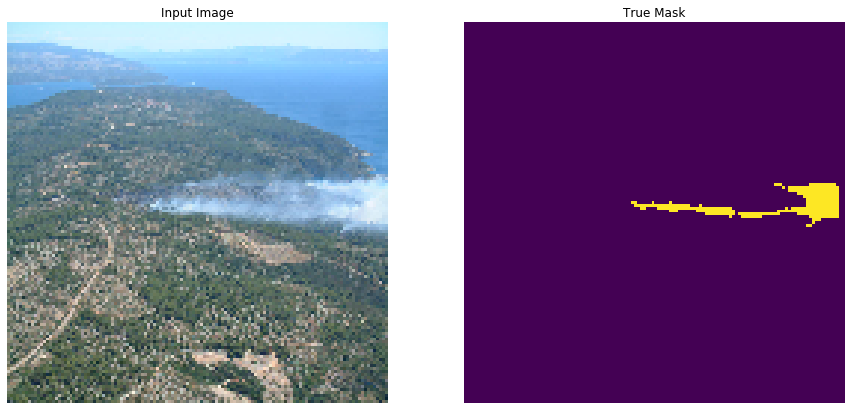

In [8]:
idx = 30
display([train_features[idx], train_labels[idx]])

#### Generate model for U-net

In [9]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

#### Import MobileNetV2 for encoder

In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu', 
    'block_3_expand_relu', 
    'block_6_expand_relu', 
    'block_13_expand_relu', 
    'block_16_project', 
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

#### Upsample function for decoder, with different regularization techniques

In [86]:
def upsample(filters, size, regul=None):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    layer = tf.keras.Sequential()
    layer.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    
    if regul == 'batchnorm':
        layer.add(tf.keras.layers.BatchNormalization())
    if regul == 'dropout':
        layer.add(tf.keras.layers.Dropout(0.2))
    layer.add(tf.keras.layers.LeakyReLU())
    return layer    

In [87]:
up_stack = [
    upsample(512, 3),
    upsample(256, 3), 
    upsample(128, 3), 
    upsample(64, 3), 
]

#### Generate U-net model based on down-stack and up-stack

In [88]:
def unet_model(output_channels):

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same', activation='softmax')  #64x64 -> 128x128

    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [89]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Show what the prediction is from untrained model

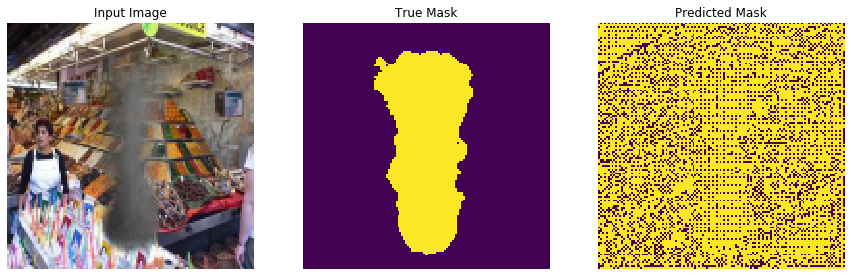

In [90]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])
sample_image, sample_mask = train_features[idx], train_labels[idx]
show_predictions()

#### Callback for monitoring model improvements over time

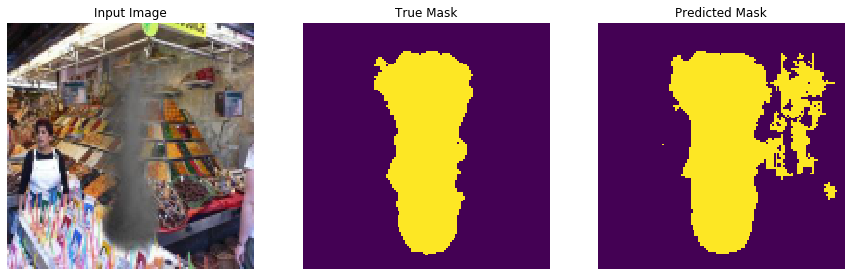


Sample Prediction after epoch 100

115/115 [==============================] - 3s 24ms/step - loss: 0.0271 - accuracy: 0.9896 - val_loss: 0.3185 - val_accuracy: 0.9168


In [91]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
TRAIN_LENGTH = len(ALL_IMGS)
        
EPOCHS = 100
VALIDATION_STEPS = 4

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

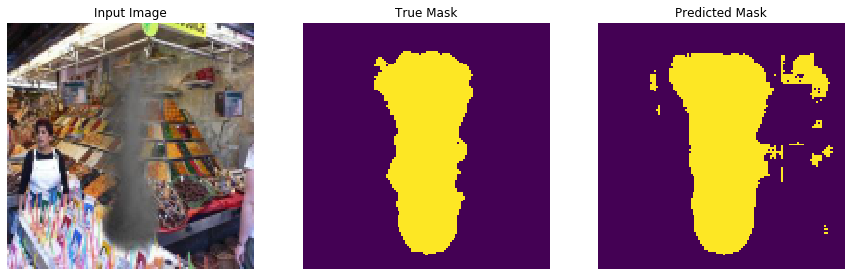

In [65]:
idx=3
sample_image, sample_mask = train_features[idx], train_labels[idx]
display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

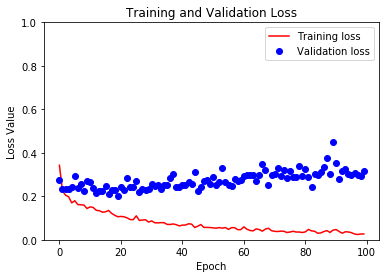

In [92]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [93]:
min_loss = min(val_loss)
print(min_loss)
[i for i, j in enumerate(val_loss) if j == min_loss]

0.20351603168707627


[19]

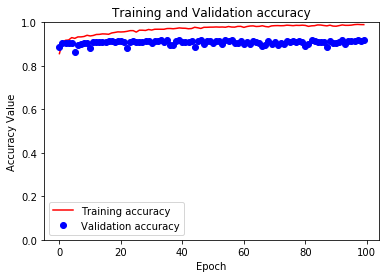

In [94]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(EPOCHS)
plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [96]:
max_acc = max(val_acc)
print(max_acc)
[i for i, j in enumerate(val_acc) if j == max_acc]

0.91856486


[56]

(0, 0.5)

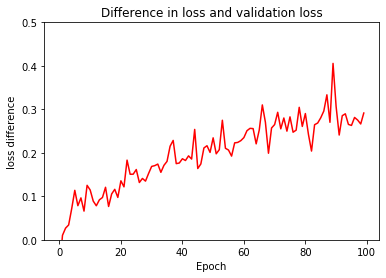

In [97]:
loss_diff = [val_loss_elem- loss_elem for loss_elem, val_loss_elem in zip(loss, val_loss)]
plt.figure()
plt.plot(epochs, loss_diff, 'r', label='loss val_loss difference')
plt.title("Difference in loss and validation loss")
plt.xlabel('Epoch')
plt.ylabel('loss difference')
plt.xlabel
plt.ylim([0, 0.5])

In [173]:
tf.keras.utils.plot_model(model, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
